# Train 3D UNet on single molecule dataset; with deeper 3D Unet; with 3 slices (head, bottom, middle)

## load data

In [6]:
import os 
import numpy as np
# from dataGenerator import imageLoader
# from dataGenerator import imageLoaderDeep
from dataGenerator import *
import keras
import matplotlib.pyplot as plt
import glob
import random
# import torchio as tio

In [7]:
# visualize

def visusalizeIMG(n_slice, test_img, test_msk):
    # n_slice = random.randint(0, test_img.shape[2])
    plt.figure(figsize=(8, 8))

    plt.subplot(121)
    plt.imshow(test_img[n_slice,:,:], cmap='gray')
    # plt.title('focal slice')
    plt.subplot(122)
    plt.imshow(test_msk[n_slice,:,:], cmap='gray')
    # plt.titSle('GT slice')
    plt.show()

In [92]:
# generate the gif

import numpy as np
from PIL import Image
import SimpleITK as sitk
import mrcfile

def saveGIF(imageGIF, labelGIF, predict, direction, gif_directory):
    
    # print('during gif') 
    
    imageGIF = imageGIF  # the original dataset is 8 bits
    stack = []
    
    # print(image.shape, label.shape, predict.shape)
    # print('image:', np.max(imageGIF), np.min(imageGIF))
    # print('label after gif: ', np.max(labelGIF), np.min(labelGIF))
    # print('predict: ', np.max(predict), np.min(predict))
    
    bar = np.ones((imageGIF.shape[0], 2)) # divide the images
    
    if direction == 0:
        print('cut along x')
    elif direction == 1:
        print('cut along y')

    elif direction == 2:
        print('cut along z')
        
    else:
        print('please specify the direction')
    
    
    for i in range(imageGIF.shape[0]):

        if direction == 0:
            temp1 = imageGIF[i,...]
            temp2 = predict[i,...]
            temp3 = labelGIF[i,...]
            
        elif direction == 1:
            temp1 = imageGIF[:,i,:]
            temp2 = predict[:,i,:]
            temp3 = labelGIF[:,i,:]
        
        elif direction == 2:
            temp1 = imageGIF[...,i]
            temp2 = predict[...,i]
            temp3 = labelGIF[...,i]
        else:
            print('illegal cut')
        
        
        # print('round:', i)
        # print('image concatenate:', temp1.shape)
        # print('label concatenate:', temp2.shape)
        # print('predict concatenate:', temp3.shape)
        
        imageTemp = np.concatenate((temp1, bar, temp2, bar, temp3), axis=1)
        # print('after concatenate:', imageTemp.shape)
        stack.append(imageTemp)
        
    stack = np.asarray(stack)
    
    # imgs = [img*255 for img in stack]
    imgs = [Image.fromarray(img*255) for img in stack]  # pil要求整体图片乘上255
    # duration is the number of milliseconds between frames; this is 40 frames per second
    imgs[0].save(gif_directory, save_all=True, append_images=imgs[1:], duration=100, loop=0)
    
    # write as nii
    # writer = sitk.ImageFileWriter()
    # writer.SetFileName('./results/result.nii')
    # writer.Execute(stack)
    
    mrc = mrcfile.new('./results/result.mrc', overwrite=True)
    mrc.set_data((stack*255).astype('int8'))
    mrc.close
    
    np.save('./results/result.npy', stack)
    

In [9]:
# specify the dir

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/data/2022_07/inputData/'

train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

train_img_list = sorted(glob.glob(train_img_dir + '/*.npy'))
train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

num_images = len(train_img_list)
print(num_images)

240


In [10]:
print('image list:', train_img_list[10])
print('mask list:', train_msk_list[10])

image list: E:/EM/demo/3D_Unet_keras/data/2022_07/inputData/train/images\image_110.npy
mask list: E:/EM/demo/3D_Unet_keras/data/2022_07/inputData/train/masks\mask_110.npy


In [11]:
# visualize the images

img_num = random.randint(0, num_images-1) # num从1开始
test_img = np.load(train_img_list[img_num])
test_img = test_img[...,0]
print('image shape:', test_img.shape)

test_mask = np.load(train_msk_list[img_num])
print('before mask:', test_mask.shape)
test_mask = np.argmax(test_mask, axis=3)
print('after mask:', test_mask.shape)

image shape: (64, 64, 64)
before mask: (64, 64, 64, 2)
after mask: (64, 64, 64)


In [12]:
#  reshape data for 2D deep UNet

# test = np.stack([test_mask], axis=3)
# print(test.shape)
test = np.expand_dims(test_mask, axis = -1)
print(test.shape)

(64, 64, 64, 1)


current slice: 32


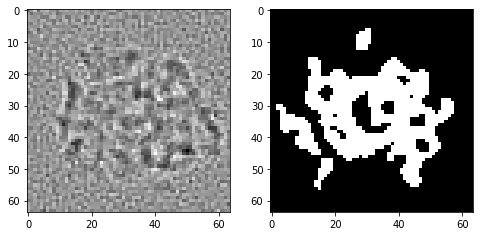

current slice: 34


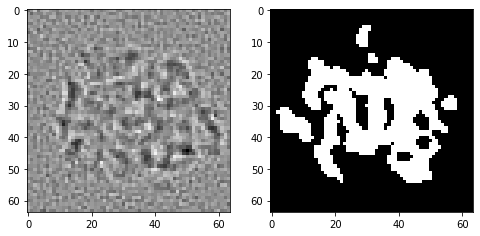

In [13]:
# visualize the images 

# n_slice = random.randint(0, test_mask.shape[2]-1)

n_slice = 32
print('current slice:', n_slice)
visusalizeIMG(n_slice, test_img, test_mask)

print('current slice:', n_slice + 2)
visusalizeIMG(n_slice + 2, test_img, test_mask)

### calculate the weight between labels. useful for weighted dice loss

In [14]:
import pandas as pd

columns = ['0', '1']
df = pd.DataFrame(columns=columns)

train_msk_list = sorted(glob.glob(train_msk_dir + '/*.npy'))

for img in range(len(train_msk_list)):
    
    # print(img)
    temp_image = np.load(train_msk_list[img])
    temp_image = np.argmax(temp_image, axis=3)  # convert back into images
    
    val, counts = np.unique(temp_image, return_counts=True) # count labels
    zipped = zip(columns, counts)
    counts_dict = dict(zipped)
    
    df = df.append(counts_dict, ignore_index = True)

In [15]:
# calculate the ratio of different labels

label_0 = df['0'].sum()
label_1 = df['1'].sum()

total_labels = label_0 + label_1
n_classes = 2

# class weight calculated: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) # 小数点后两位
wt1 = round((total_labels/(n_classes*label_1)), 2)

print(wt0, wt1)

0.56 4.4


## Define the image generator

In [16]:
# data path and sort

from natsort import natsorted

DATA_PATH = 'E:/EM/demo/3D_Unet_keras/data/2022_08/inputData/'

train_img_dir = DATA_PATH + 'train/images/'
train_msk_dir = DATA_PATH + 'train/masks/'

train_img_list = natsorted(os.listdir(train_img_dir))
train_msk_list = natsorted(os.listdir(train_msk_dir))

# validation
val_img_dir = DATA_PATH + 'val/images/'
val_msk_dir = DATA_PATH + 'val/masks/'

val_img_list = natsorted(os.listdir(val_img_dir))
val_msk_list = natsorted(os.listdir(val_msk_dir))

# testing
test_img_dir = DATA_PATH + 'test/images/'
test_msk_dir = DATA_PATH + 'test/masks/'

test_img_list = natsorted(os.listdir(test_img_dir))
test_msk_list = natsorted(os.listdir(test_msk_dir))

print('train images:', len(train_img_list))
print('val images:', len(val_img_list))
print('test images:', len(test_img_list))

train images: 160
val images: 40
test images: 100


In [17]:
# data generator for training

batch_size = 2

train_img_datagen = imageLoader3DSlice(train_img_dir, train_img_list,
                               train_msk_dir, train_msk_list, batch_size)

val_img_datagen = imageLoader3DSlice(val_img_dir, val_img_list,
                             val_msk_dir, val_msk_list, batch_size)

image gen: (2, 64, 64, 64, 1)
mask gen: (2, 64, 64, 64, 1)
(64, 64, 64)
slice num: 43


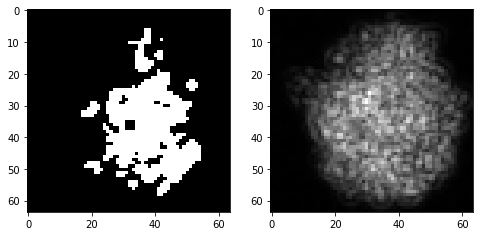

In [18]:
# visualize the data generator

img, msk = train_img_datagen.__next__()
print('image gen:', img.shape)
print('mask gen:', msk.shape)

stack_num = random.randint(0, img.shape[0]-1)
test_img = np.squeeze(img[stack_num,...])
test_mask = np.squeeze(msk[stack_num,...])
print(test_img.shape)

n_slice=random.randint(0, test_mask.shape[1]-1)
# n_slice = 50

print('slice num:', n_slice)
visusalizeIMG(n_slice, test_mask, test_img)

## Define the loss, metrics and optimizer for training

In [19]:
# wt0, wt1 = 0.5,0.5
wt0, wt1 = 0.56,4.4

import segmentation_models_3D as sm

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1]))  # default is uniform
focal_loss = sm.losses.CategoricalFocalLoss()
BCE_loss = sm.losses.BinaryCELoss()

total_loss = dice_loss*0.005 + (1* focal_loss) + BCE_loss*1  # works for most segmentation jobs

# metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]  # metrics for final performance
metrics = [sm.metrics.IOUScore(threshold=0.5)]  # metrics for final performance
# metrics = ['accuracy', sm.metrics.FScore(beta=1)] # F1 score

LR = 0.0001
optim = keras.optimizers.Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [20]:
# 调试用loss function

# loss function designed from scratch

# import tensorflow as tf
# import tensorflow.keras.backend as K

# LR = 0.0001
# optim = keras.optimizers.Adam(LR)


# # soft dice
# def dice_coef(y_true, y_pred, smooth=100):        
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = K.sum(y_true_f * y_pred_f)
#     dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return dice


# def loss_function(y_true, y_pred):
#     dice_loss = -dice_coef(y_true, y_pred)
#     l1_loss = tf.math.reduce_mean(tf.math.abs(y_true - y_pred), axis=(1,2,3))  # tranfer matrix into value
#     SCE = tf.keras.metrics.binary_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=0.0, axis=-1)
    
#     # print('SCE shape:', SCE.shape)
    
#     # ssim_loss = tf.image.ssim_multiscale(y_true, y_pred, max_val=1)
    
#     total_loss = dice_loss*0.05 + l1_loss*0.5  + tf.math.reduce_mean(SCE, axis=(1,2))*1  #CE_loss #ssim_loss    # weight should be tuned SCE #
    
    
#     return total_loss

# jaccard_loss = JaccardLoss()
# dice_loss = DiceLoss()

# binary_focal_loss = BinaryFocalLoss()
# categorical_focal_loss = CategoricalFocalLoss()

# binary_crossentropy = BinaryCELoss()
# categorical_crossentropy = CategoricalCELoss()

# # loss combinations
# bce_dice_loss = binary_crossentropy + dice_loss
# bce_jaccard_loss = binary_crossentropy + jaccard_loss

# cce_dice_loss = categorical_crossentropy + dice_loss
# cce_jaccard_loss = categorical_crossentropy + jaccard_loss

# binary_focal_dice_loss = binary_focal_loss + dice_loss
# binary_focal_jaccard_loss = binary_focal_loss + jaccard_loss

# categorical_focal_dice_loss = categorical_focal_loss + dice_loss
# categorical_focal_jaccard_loss = categorical_focal_loss + jaccard_loss

## Fit the model

In [21]:
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

In [22]:
# load model from transfer learning

from model.simple3DUnet_512 import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=64,
                         IMG_WIDTH=64,
                         IMG_DEPTH=64,
                         IMG_CHANNELS=1,
                         num_classes=1)   # change the num; 2->1. G.

model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
# model.compile(optimizer=optim, loss=loss_function, metrics=[dice_coef]) 

# print(model.summary())
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 64, 64, 64,   1312        ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 instance_normalization (Instan  (None, 64, 64, 64,   32         ['conv3d[0][0]']                 
 ceNormalization)               16)                                                           

## Train and save model

### 测试batch 训练。用padding使用几张图片

### Torch io padding. kernel dies

In [18]:
img, msk = train_img_datagen.__next__()

test1 = np.squeeze(img)
test3 = test1[:,32,...]
test2 = np.stack([test3, test3, test3], axis=1)

print(img.shape, test3.shape, test2.shape)

(2, 64, 64, 64, 1) (2, 64, 64) (2, 3, 64, 64)


In [19]:
import torchio as tio

def slice2Stack(img, SIZE):
    stackTemp = np.squeeze(img)
    sliceTemp = np.stack([stackTemp[:,0,...], stackTemp[:,31,...], stackTemp[:,63,...]], axis=1)  # take the 3 slice from stacks
    tioTemp = sliceTemp.transpose((3,2,1,0))
    
    trainIO = tio.ScalarImage(tensor=tioTemp)
    target_shape = SIZE
    
    crop_pad = tio.CropOrPad(target_shape, padding_mode='mean')
    resized = crop_pad(trainIO) # padding with mean
    train_pad = resized.numpy().transpose((3,1,2,0))
    return train_pad

### Simpleitk

In [18]:
import SimpleITK as sitk

def resample_sitk_image(sitk_image, spacing=None, interpolator=None, fill_value=0):
    # https://github.com/SimpleITK/SlicerSimpleFilters/blob/master/SimpleFilters/SimpleFilters.py
    _SITK_INTERPOLATOR_DICT = {
        'nearest': sitk.sitkNearestNeighbor,
        'linear': sitk.sitkLinear,
        'gaussian': sitk.sitkGaussian,
        'label_gaussian': sitk.sitkLabelGaussian,
        'bspline': sitk.sitkBSpline,
        'hamming_sinc': sitk.sitkHammingWindowedSinc,
        'cosine_windowed_sinc': sitk.sitkCosineWindowedSinc,
        'welch_windowed_sinc': sitk.sitkWelchWindowedSinc,
        'lanczos_windowed_sinc': sitk.sitkLanczosWindowedSinc
    }

    if isinstance(sitk_image, str):
        sitk_image = sitk.ReadImage(sitk_image)
    
    # Roy 从sitk拿出图像部分
    # sitk_image = sitk.GetImageFromArray(sitk_image)
    num_dim = sitk_image.GetDimension()

    if not interpolator:
        interpolator = 'linear'
        pixelid = sitk_image.GetPixelIDValue()

        if pixelid not in [1, 2, 4]:
            raise NotImplementedError(
                'Set `interpolator` manually, '
                'can only infer for 8-bit unsigned or 16, 32-bit signed integers')
        if pixelid == 1:  # 8-bit unsigned int
            interpolator = 'nearest'

    orig_pixelid = sitk_image.GetPixelIDValue()
    orig_origin = sitk_image.GetOrigin()
    orig_direction = sitk_image.GetDirection()
    orig_spacing = np.array(sitk_image.GetSpacing())
    orig_size = np.array(sitk_image.GetSize(), dtype=np.int)

    if not spacing:
        min_spacing = orig_spacing.min()
        new_spacing = [min_spacing] * num_dim
    else:
        new_spacing = [float(s) for s in spacing]

    assert interpolator in _SITK_INTERPOLATOR_DICT.keys(), \
        '`interpolator` should be one of {}'.format(_SITK_INTERPOLATOR_DICT.keys())

    sitk_interpolator = _SITK_INTERPOLATOR_DICT[interpolator]

    new_size = orig_size * (orig_spacing / new_spacing)
    new_size = np.ceil(new_size).astype(np.int)  # Image dimensions are in integers
    new_size = [int(s) for s in new_size]  # SimpleITK expects lists, not ndarrays

    resample_filter = sitk.ResampleImageFilter()

    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize(new_size)
    resample_filter.SetOutputDirection(orig_direction)
    resample_filter.SetOutputOrigin(orig_origin)
    resample_filter.SetTransform(sitk.Transform())
    resample_filter.SetDefaultPixelValue(orig_pixelid)
    resample_filter.SetInterpolator(sitk_interpolator)
    resample_filter.SetDefaultPixelValue(fill_value)

    resampled_sitk_image = resample_filter.Execute(sitk_image)

    return resampled_sitk_image


def slice2stack(sliceStack, SPACE):
    pad_stack = []
    
    for i in range(sliceStack.shape[0]):
        img_stk = sitk.GetImageFromArray(sliceStack[i], isVector=True)
        img_afterAug = resample_sitk_image(img_stk, spacing=SPACE, interpolator='linear', fill_value=0)
        img_aug = sitk.GetArrayFromImage(img_afterAug)
        # print(img_aug.shape)
        pad_stack.append(img_aug)
    
    pad_stack = np.asarray(pad_stack)
    return np.expand_dims(pad_stack, axis=4)  # [t, W, H, D, CH]

### 测试batch

2/2 [==============================] - 1s 8ms/step
0 [0.9134465456008911, 0.0954236313700676]


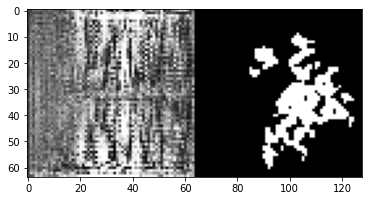

2/2 [==============================] - 0s 45ms/step
100 [0.5724455118179321, 0.4192957580089569]


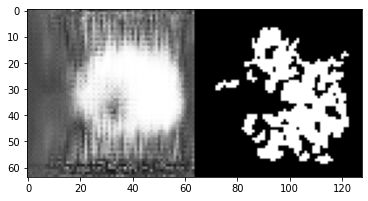

2/2 [==============================] - 0s 43ms/step
200 [0.5950047969818115, 0.30685776472091675]


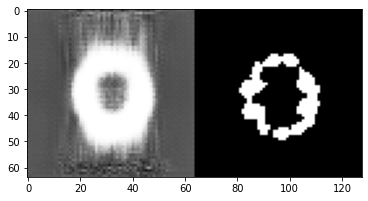

2/2 [==============================] - 0s 45ms/step
300 [0.5161663293838501, 0.5385239124298096]


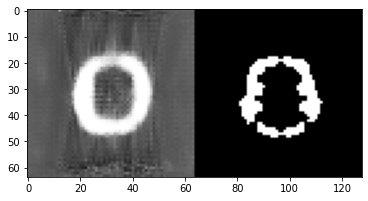

2/2 [==============================] - 0s 45ms/step
400 [0.5067431330680847, 0.42332693934440613]


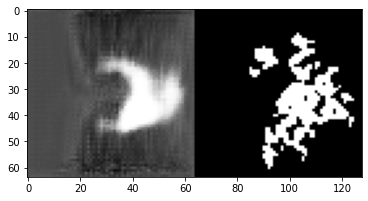

In [18]:
# 测试per batch
# train_on_batch

NUM_STEPS = 500

# model.summary()

for step in range(NUM_STEPS):
    
    img, msk = train_img_datagen.__next__()
    
    loss = model.train_on_batch(img, msk)  # control the way to consume MM
    
    # print(step, loss)
    
    if step % 1000 == 0:
        # model.save_weights('./modelDeep_loss.hdf5')
        model.save('./weight/modelDeep_3D_512_batch_slice.hdf5')  # directly save the whole model
        
    if step % 100 == 0:
        prediction = model.predict(img,batch_size=1)
        # print(prediction.shape, msk.shape)
        # print(prediction[0,:,32,:,:].shape, msk[0,:,32,:].shape)
        print(step, loss)
        plt.imshow(np.concatenate((np.squeeze(prediction[0,:,32,:,:]), np.squeeze(msk[0,:,32,:,:])), axis=1),cmap='gray')
        plt.show()
        plt.close('all')


(2, 64, 64, 64, 1) (2, 64, 64, 64, 1)
slice Num: 15


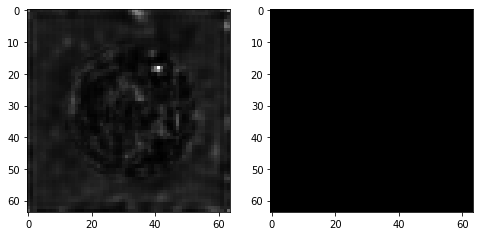

In [82]:
# visualize of last training images

showPred = prediction
showMask = msk
showIMG = img
print(showPred.shape, showMask.shape)
n_slice = random.randint(0, showPred.shape[1])

NUM = 0
print('slice Num:', n_slice)
visusalizeIMG(n_slice, showPred[NUM,...], showMask[NUM,...])

In [74]:
# generate one gif of the stack

NUM = 1
direction = 0
gif_directory = './results/result_slice.gif'

saveGIF(showIMG[NUM,...].squeeze(), showMask[NUM,...].squeeze(), showPred[NUM,...].squeeze(), direction, gif_directory)


cut along x


In [64]:
test = showIMG[NUM,...].squeeze()
print(test.shape)

(64, 64, 64)


### Train in fit

In [18]:
import tensorflow.keras as k

callbacks = [
    k.callbacks.EarlyStopping(patience=15, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir = './tensorBoard/3D/512/')]

In [19]:

# original model
EPOCHS = 50

history = model.fit(train_img_datagen,
                   steps_per_epoch=steps_per_epoch,
                   epochs=EPOCHS,
                   verbose=1, # ??
                   validation_data=val_img_datagen,
                   validation_steps=val_steps_per_epoch, callbacks=callbacks)


MODEL_PATH = 'E:/EM/demo/3D_Unet_keras/weight/'

model.save(MODEL_PATH + 'deep_3d_512' + '_202208_' + str(EPOCHS) + '_slice.hdf5')

Epoch 1/50
80/80 [==============================] - 37s 329ms/step - loss: 0.7007 - iou_score: 0.2074 - val_loss: 0.6243 - val_iou_score: 0.2907
Epoch 2/50
80/80 [==============================] - 23s 291ms/step - loss: 0.5931 - iou_score: 0.3666 - val_loss: 0.5865 - val_iou_score: 0.3930
Epoch 3/50
80/80 [==============================] - 23s 286ms/step - loss: 0.5590 - iou_score: 0.4232 - val_loss: 0.5610 - val_iou_score: 0.4471
Epoch 4/50
80/80 [==============================] - 23s 284ms/step - loss: 0.5299 - iou_score: 0.4565 - val_loss: 0.5416 - val_iou_score: 0.4651
Epoch 5/50
80/80 [==============================] - 24s 298ms/step - loss: 0.5035 - iou_score: 0.4775 - val_loss: 0.5205 - val_iou_score: 0.4825
Epoch 6/50
80/80 [==============================] - 23s 287ms/step - loss: 0.4799 - iou_score: 0.4938 - val_loss: 0.5028 - val_iou_score: 0.4913
Epoch 7/50
80/80 [==============================] - 23s 287ms/step - loss: 0.4567 - iou_score: 0.5036 - val_loss: 0.4794 - val_iou

## Visualize the training process

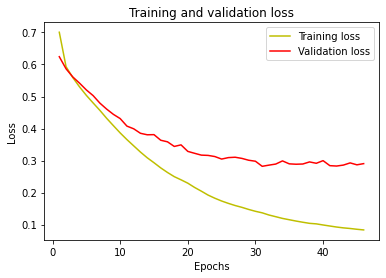

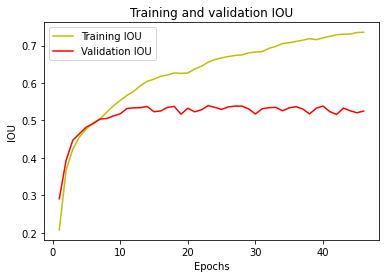

In [20]:

FIG_PATH = './reports/'

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(FIG_PATH + 'loss_3D_512_2022_08_slice.png', dpi=300, bbox_inches = 'tight')
plt.show()


# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training accuracy')
# plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# IoU
IoU = history.history['iou_score']
val_iou = history.history['val_iou_score']
plt.figure()
plt.plot(epochs, IoU, 'y', label='Training IOU')
plt.plot(epochs, val_iou, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.savefig(FIG_PATH + 'IoU_3D_512_2022_08_slice.png', dpi=300, bbox_inches = 'tight')
plt.show()

## Predict the test dataset of single image

In [23]:
# load in the model

from keras.models import load_model

EPOCHS = 50
MODEL_PATH = 'E:/EM/demo/3D_Unet_keras/weight/'

my_model = load_model(MODEL_PATH + 'deep_3d_512' + '_202208_' + str(EPOCHS) + '_slice.hdf5', compile=False)
# my_model = load_model('./weight/deep_3D_512_50.hdf5', compile=False)

In [24]:
# for prediction verify IoU

from keras.metrics import MeanIoU

batch_size = 4  # prediction batch

test_img_datagen = imageLoader3DSlice(test_img_dir, test_img_list,
                              test_msk_dir, test_msk_list, batch_size)

In [25]:
# verify the generator

test_image_batch, test_mask_batch = test_img_datagen.__next__()  
print('before:', test_mask_batch.shape)
# test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4) # convert onehot back to integer
# print('after:', test_mask_batch_argmax.shape)

before: (4, 64, 64, 64, 1)


In [26]:
# predict

test_pred_batch = my_model.predict(test_image_batch)
print(test_pred_batch.shape)
test_pred_batch = np.expand_dims(np.squeeze(test_pred_batch), axis=4)
print(test_pred_batch.shape, test_mask_batch.shape)

1/1 [==============================] - 7s 7s/step
(4, 64, 64, 64, 1)
(4, 64, 64, 64, 1) (4, 64, 64, 64, 1)


In [27]:
# n_classes = 2

n_classesG = 2
IOU_keras = MeanIoU(num_classes=n_classesG)  
IOU_keras.update_state(np.squeeze(test_pred_batch), np.squeeze(test_mask_batch))
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.5878671


## Predict the test dataset of multiple image

In [87]:
img_num = 10  # the name in test dataset

test_img = np.load(DATA_PATH + '/train/images/image_'+str(img_num)+'.npy')

test_mask = np.load(DATA_PATH + '/train/masks/mask_'+str(img_num)+'.npy')
# print(test_img.shape, test_mask.shape)
test_mask_argmax = np.argmax(test_mask, axis=3)
# test_mask_argmax = np.expand_dims(test_mask_argmax, axis=3)
print(test_img.shape, test_mask_argmax.shape)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction = np.squeeze(test_prediction[0,...])
print(test_prediction.shape)

(64, 64, 64, 1) (64, 64, 64)
1/1 [==============================] - 0s 20ms/step
(64, 64, 64)


current slice: 9


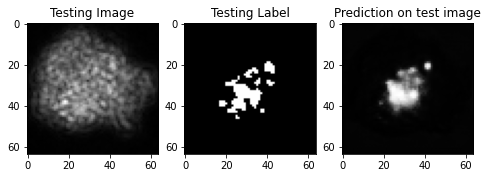

In [88]:
# visualize in x direction

n_slice = random.randint(0, test_prediction.shape[0]-1)

print('current slice:', n_slice)
plt.figure(figsize=(8, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[n_slice,:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[n_slice,:,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction[n_slice,:,:], cmap='gray')
plt.show()

current slice: 6


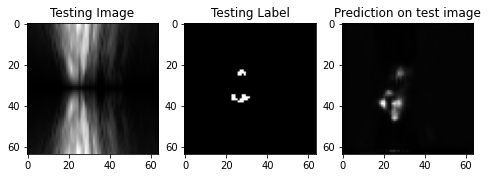

In [89]:
# visualize in y direction

n_slice = random.randint(0, test_prediction.shape[0]-1)

print('current slice:', n_slice)

plt.figure(figsize=(8, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,n_slice,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,n_slice,:], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction[:,n_slice,:], cmap='gray')
plt.show()

### Save the gif

(64, 64, 64) (64, 64, 64) (64, 64, 64)
slice Num: 31


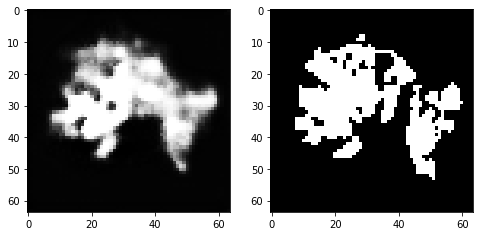

In [90]:
# visualize of last training images

showPred = test_prediction
showMask = test_mask_argmax
showIMG = test_img.squeeze()
print(showPred.shape, showMask.shape, showIMG.shape)
n_slice = random.randint(0, showPred.shape[1])

print('slice Num:', n_slice)
visusalizeIMG(n_slice, showPred, showMask)

In [93]:
# generate one gif of the stack

NUM = 1
direction = 0
gif_directory = './results/result_slice_3.gif'

saveGIF(showIMG, showMask, showPred, direction, gif_directory)

cut along x
